# CSPB4502 Spring 2022 Final Project: Anime Recommendation System

Group 1: Matthew Fournier, Christie Hui

In [55]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.stats
import seaborn as sns
sns.set_style('whitegrid')
import math

### Overview of Project

The aim of this project is to create an anime recommendation system for users based on existing user data obtained from MyAnimeList.net, which is essentially a cataloging site which allows users to keep lists of which anime they’ve seen/plan to see, view user reviews of anime titles, and rate shows based on a scale from 1-10. The motivation behind choosing this topic is due to a shared common interest in anime as well as prior familiarity with MyAnimeList site functionality. The knowledge and results gained from the analysis of this data set may be beneficial for future personal decisions regarding choosing an anime to watch.

Based on certain features from the data set – such as anime titles, genres, and ratings, to name a few – we aim to discover and answer interesting questions such as:

- Which genres (of anime) contribute to ambiguous users’ watching decisions?
- How much do features such as rating, episode count, and anime type influence a user’s viewing choices?
- Is the popularity of an anime or similarity to other users’ profiles/viewing preferences more significant in impacting a user’s preferences?

Our project will aim to answer the questions above at minimum.

### Description of Data

The data set was obtained from Kaggle.com: https://www.kaggle.com/CooperUnion/anime-recommendations-database. The data set is comprised of two separate CSV files, Anime.csv and Rating.csv, and it contains information on user preference data from 73,516 users on 12,294 different anime titles from the website MyAnimeList.net. Each user has the ability to add an anime title to their watched anime list along with a rating out of 1-10.

The Anime.csv file contains the columns: 
- anime_id (the unique identifier assigned to an anime title by MyAnimeList)
- name (full name of anime title)
- genre (comma separated list of genres for an anime title)
- type (whether the anime is a movie, OVA, TV episode, etc.)
- number of episodes (how many episodes for a given anime title, given a value of 1 if the type is a movie)
- rating (average rating out of 10 for an anime title)
- members (the amount of users on the site who have added a particular anime to their profile)

The Rating.csv file contains the columns: 
- user_id (a randomly generated user ID)
- anime_id (the unique identifier assigned to an anime that the particular user has rated)
- rating (the rating out of 1-10 that the particular user has assigned, given a value of -1 in the data set if no rating was assigned)

### Data Preprocessing

In [56]:
anime = pd.read_csv('anime.csv')

In [57]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [58]:
users = pd.read_csv('rating.csv')

In [59]:
users.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [60]:
anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [61]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


In [62]:
users.count()

user_id     7813737
anime_id    7813737
rating      7813737
dtype: int64

Text(0.5, 1.0, 'Rating Distribution')

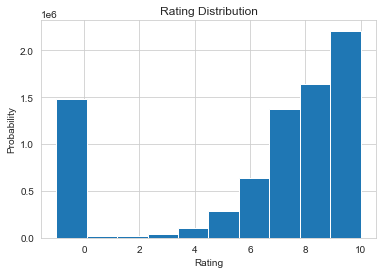

In [63]:
#naive data dispersion
plt.hist(users['rating'], bins = 10)
plt.ylabel('Probability')
plt.xlabel('Rating')
plt.title('Rating Distribution')

In [64]:
# total counts for each rating

users.rating.value_counts()

 8     1646019
-1     1476496
 7     1375287
 9     1254096
 10     955715
 6      637775
 5      282806
 4      104291
 3       41453
 2       23150
 1       16649
Name: rating, dtype: int64

As seen from the preview of the users dataframe as well as the count distribution for each rating, the rating.csv file contains a large number of the integer value -1 (1476496 values out of 7813737) for anime listings in which users did not assign a rating. Since users did not assign a rating to these anime entries, we will simply drop the rows with the value of -1 in the rating column.

In [65]:
users = users[users['rating'] != -1]

We also want to update our anime dataframe to include TV anime types only, since our recommendation system will be recommending anime series.

In [66]:
anime = anime[anime['type']=='TV']

After updating these values, we can merge the two dataframes based on the anime_id attribute in order to get the name of the anime titles.

In [67]:
rated_anime = pd.merge(users,anime[['anime_id','name']], left_on = 'anime_id', right_on = 'anime_id').drop('anime_id', axis=1)

In [68]:
rated_anime.head(10)

,user_id,rating,name
0,1,10,Highschool of the Dead
1,3,6,Highschool of the Dead
2,5,2,Highschool of the Dead
3,12,6,Highschool of the Dead
4,14,6,Highschool of the Dead
5,17,7,Highschool of the Dead
6,24,7,Highschool of the Dead
7,27,9,Highschool of the Dead
8,29,2,Highschool of the Dead
9,30,8,Highschool of the Dead


After merging the two dataframes, we can do some further exploration of the relationship between various anime titles and their ratings. Let's take a look at some of the supposedly top rated anime:

In [69]:
rated_anime.corr()

,user_id,rating
user_id,1.000000,0.003054
rating,0.003054,1.000000


In [70]:
rated_anime.groupby('name')['rating'].mean().sort_values(ascending=False).head(10)

name
Gozonji! Gekkou Kamen-kun                    10.0
Choegang Top Plate                           10.0
Play Ball 2nd                                10.0
Hamster Club                                 10.0
Sekai Meisaku Douwa: Wow! Maerchen Oukoku    10.0
Yattokame Tanteidan                          10.0
Robotan                                      10.0
What&#039;s Michael? (TV)                    10.0
Takoyaki Mant-Man                            10.0
Only You: Viva! Cabaret Club                 10.0
Name: rating, dtype: float64

This is interesting because there appears to be an anime with a rating of 10, which is a bit curious.  We can include another attribute from the data sets in order to get a better recommendation.  One attribute that we can use is the number of users, since the higher the number of users that have watched a particular anime title, the higher the likelihood is that the anime title would have a less skewed/biased rating.

In [71]:
rated_anime.groupby('name')['rating'].count().sort_values(ascending=False).head(10)

name
Death Note                            34226
Sword Art Online                      26310
Shingeki no Kyojin                    25290
Code Geass: Hangyaku no Lelouch       24126
Angel Beats!                          23565
Elfen Lied                            23528
Naruto                                22071
Fullmetal Alchemist: Brotherhood      21494
Fullmetal Alchemist                   21332
Code Geass: Hangyaku no Lelouch R2    21124
Name: rating, dtype: int64

### Exploratory Data Analysis

Now that we've done a bit of data preprocessing, let's do some further analysis centered around the "ratings" attribute.

In [72]:
rated_anime['user_id'].value_counts()

42635    1953
57620    1485
59643    1442
45659    1315
7345     1182
         ... 
25756       1
2704        1
3854        1
13462       1
38212       1
Name: user_id, Length: 68929, dtype: int64

From the code snippet above, we can see that there are several users in the data frame who have only assigned a rating once. We will go ahead and assume that these entries will not contribute meaningfully to our analysis, so we will define a minimum threshold of 200 ratings for users.

In [73]:
counts = rated_anime['user_id'].value_counts()
rated_anime = rated_anime[rated_anime['user_id'].isin(counts[counts >= 200].index)]
rated_anime['user_id'].value_counts()

42635    1953
57620    1485
59643    1442
45659    1315
7345     1182
         ... 
11871     200
69737     200
20100     200
22470     200
61438     200
Name: user_id, Length: 4687, dtype: int64

In [74]:
ratings = pd.DataFrame(rated_anime.groupby('name')['rating'].mean())
ratings['number of ratings'] = pd.DataFrame(rated_anime.groupby('name')['rating'].count())
count_rating = rated_anime.groupby('name')['rating'].count().sort_values(ascending=False)
ratings.head(10)

,rating,number of ratings
name,,
.hack//Roots,7.035959,584
.hack//Sign,7.126305,958
.hack//Tasogare no Udewa Densetsu,6.691901,568
009-1,6.442478,113
07-Ghost,7.250877,1140
11eyes,6.577082,1693
12-sai.: Chicchana Mune no Tokimeki,6.844156,77
21 Emon,5.000000,1
3 Choume no Tama: Uchi no Tama Shirimasenka?,7.000000,11


array([[<AxesSubplot:title={'center':'rating'}>]], dtype=object)

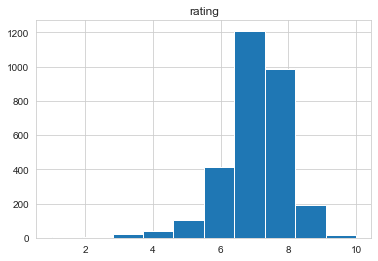

In [75]:
# looking at the distribution of ratings
ratings.hist('rating')

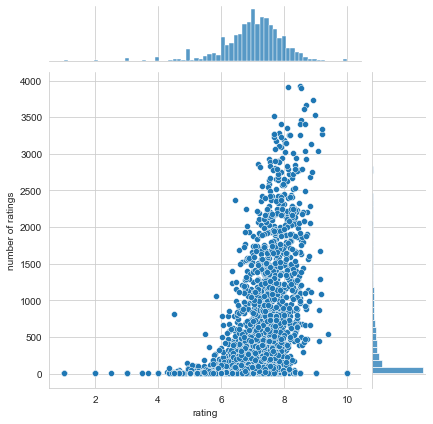

In [76]:
sns.jointplot(x='rating',y='number of ratings',data=ratings)

From the scatterplot above, we can observe that the more users there are that give a rating for an anime title, there is an increased likelihood that it receives an overall higher rating.

### Recommendation System Algorithms and Models

Now that we've preprocessed the data from the two data sets and performed a basic EDA, we can go ahead and flesh out the anime recommendation system.  The goal of the recommendation system, as stated previously, is to generate an anime series recommendation based on existing user ratings and a provided title.

First we will start off with a simple recommendation system utilizing a pivot table and correlation between user ratings.  We have also imposed a minimum threshold of 1000 ratings for each anime to be considered in our simple recommendation system.  After filtering the data frame with this condition, we can observe that the number of rows in the data frame decreased from 1456837 to 953581 rows.

In [77]:
# Keep anime with at least min_ratings number of ratings

min_ratings = 1000
valid = count_rating[count_rating.apply(lambda x: x >= min_ratings)].index

# update data frame
anime_rec = rated_anime[rated_anime['name'].apply(lambda x: x in valid)]

In [78]:
rows_before = rated_anime.shape[0]
rows_after = anime_rec.shape[0]
print(f'''{rows_before} rows before filtering -> {rows_after} rows after filtering''')

1456837 rows before filtering -> 953581 rows after filtering


In [79]:
# create sparse matrix with user_id as rows and the titles of the anime as columns
# each cell contains the rating given by the user for the anime

df_rec = anime_rec.pivot_table(index='user_id',columns=['name'],values='rating').fillna(0)
df_rec.head()

name,07-Ghost,11eyes,Aa! Megami-sama! (TV),Absolute Duo,Accel World,Acchi Kocchi (TV),Afro Samurai,Air,Air Gear,Akagami no Shirayuki-hime,...,Zero no Tsukaima: Futatsuki no Kishi,Zero no Tsukaima: Princesses no Rondo,Zetman,Zetsuen no Tempest,Zoku Natsume Yuujinchou,Zombie-Loan,ef: A Tale of Melodies.,ef: A Tale of Memories.,xxxHOLiC,xxxHOLiC Kei
user_id,,,,,,,,,,,,,,,,,,,,,
5,0.0,0.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
7,0.0,0.0,0.0,8.0,8.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0
38,0.0,1.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43,0.0,9.0,0.0,7.0,8.0,0.0,7.0,0.0,8.0,0.0,...,6.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,7.0,7.0


In [80]:
# function to find correlation of anime with others

def find_correlation(df, name):
    similar = df.corrwith(df[name])
    similar = pd.DataFrame(similar,columns=['Correlation'])
    similar = similar.sort_values(by = 'Correlation', ascending=False)
    
    return similar

Now let's test our simple recommendation system based off of correlation using a few examples.

In [81]:
anime1 = 'Naruto'

# find recommendation for user input of Naruto
find_correlation(df_rec, anime1).head(10)

,Correlation
name,
Naruto,1.000000
Bleach,0.426035
Fairy Tail,0.307742
Katekyo Hitman Reborn!,0.280213
Dragon Ball Z,0.263396
D.Gray-man,0.249084
Dragon Ball,0.244696
Dragon Ball GT,0.235358
Shijou Saikyou no Deshi Kenichi,0.221060


In [82]:
anime2 = 'Psycho-Pass'

# find recommendation for user input of Psycho-Pass
find_correlation(df_rec, anime2).head(10)

,Correlation
name,
Psycho-Pass,1.000000
Psycho-Pass 2,0.624337
Zankyou no Terror,0.383839
Death Parade,0.341469
Shinsekai yori,0.335916
Shingeki no Kyojin,0.309546
Zetsuen no Tempest,0.307261
Steins;Gate,0.295788
Kiseijuu: Sei no Kakuritsu,0.292112


In [83]:
anime3 = 'Haikyuu!!'

# find recommendation for user input of Haikyu!!
find_correlation(df_rec, anime3).head(10)

,Correlation
name,
Haikyuu!!,1.000000
Haikyuu!! Second Season,0.761740
Kuroko no Basket 2nd Season,0.569157
Kuroko no Basket,0.537163
Kuroko no Basket 3rd Season,0.526450
Free!,0.359566
Barakamon,0.336451
Shigatsu wa Kimi no Uso,0.327876
Shokugeki no Souma,0.320285


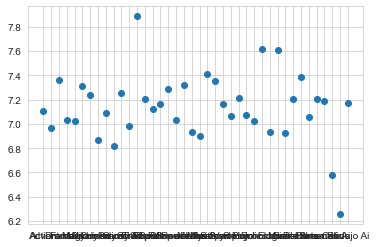

In [84]:
# This code sets up genres and ratings in a singular database and aggregates to the genre level
# We wanted to get a naive look at if there is any large variances based on the genre alone 
# in terms of rating the show higher or lower.
genredf = anime
genredf['rating'] = genredf['rating'].apply(lambda x: np.nan if x == -1 else x)
genrerating = genredf[['genre','rating']].values.tolist()
genreratingdict = {}
genrecount = {}
for i in genrerating:
    if str(i[0]) == 'nan':
        continue
    if str(i[1]) == 'nan':
        continue
    temp = [i[0].split(', '),i[1]]
    for j in temp[0]:
        if j not in genreratingdict:
            genreratingdict[j] = float(temp[1])
            genrecount[j] = 1
        else:
            genreratingdict[j] += float(temp[1])
            genrecount[j] += 1
    temp = []

output = []
for key, value in genreratingdict.items():
    temp = [key, value/float(genrecount.get(key))]
    output.append(temp)

genres = pd.DataFrame(output)
genres.columns = ['genre', 'rating']

plt.scatter(x=genres['genre'], y=genres['rating'])
plt.show()

### Modeling and Analysis of Classification based Machine Learning Models for Anime Recommendation

With this code below we are trying to see if we can utilize classification models (Decision Tree and Random Forest) that will predict with a high level of confidence some recommendations of shows that someone would watch based on knowing a few shows that they like.

### Machine Learning Implementation

The problem that we are attempting to solve is to predict a show that the user will enjoy with confidence. If you are to look at enjoyment for its face value there are only two sides of the coin, satisfaction and dissatisfaction. When you have a decision in machine learning that only has two measurable outcomes we call that a classification problem. Below is an implementation of two different types of classification algorithms.

In [85]:
# function sets 0 for false and 1 for true in a new row for the machine learning classification
def calc(row):
    if row['rating'] >=7:
        return 1
    else:
        return 0

#setup, prep and cleaning of data for model fitting
genredf = pd.read_csv('anime.csv')
ratingsdf = pd.read_csv('rating.csv').dropna()
ratingsdf = ratingsdf[ratingsdf['rating'] != -1]
genredf = genredf[genredf.type == 'TV']
genredf1 = genredf.drop(columns = ['name', 'type', 'episodes', 'rating', 'members', 'anime_id'])
res = genredf.join(genredf1['genre'].str.split(', ').str.join('|').str.get_dummies())
res = res.drop(columns = ['genre', 'type', 'name', 'rating'])
res = res[res.episodes.apply(lambda x: x.isnumeric())]
res = res.astype({'episodes': 'int64'})
res = res.dropna()
res = ratingsdf.merge(res, left_on='anime_id', right_on='anime_id')
res['recommendation'] = res.apply(calc, axis=1)
res

,user_id,anime_id,rating,episodes,members,Action,Adventure,Cars,Comedy,Dementia,...,Shounen,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,recommendation
0,1,8074,10,12,535892,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,3,8074,6,12,535892,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,5,8074,2,12,535892,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,12,8074,6,12,535892,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,14,8074,6,12,535892,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4364288,66449,3164,8,13,260,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4364289,67836,8123,8,151,536,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
4364290,67836,12091,7,25,199,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4364291,68458,8478,9,20,151,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [86]:
# xdf is an extra data frame so we can seperate res from the model, we get rid
# of some columns that would impact the model prediction
xdf = res.drop(columns=['recommendation', 'rating', 'anime_id', 'user_id'])
xdf

,episodes,members,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,...,Shoujo Ai,Shounen,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire
0,12,535892,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,12,535892,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,12,535892,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,12,535892,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,12,535892,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4364288,13,260,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4364289,151,536,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4364290,25,199,1,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4364291,20,151,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [87]:
# This is the setup for the model with the X and y variables required
X = xdf.iloc[:, :].values
features = list(res.drop(columns=['recommendation', 'rating', 'anime_id', 'user_id']).columns)
y = res['recommendation']
print(X.shape, y.shape)
print(features)

(4364293, 42) (4364293,)
['episodes', 'members', 'Action', 'Adventure', 'Cars', 'Comedy', 'Dementia', 'Demons', 'Drama', 'Ecchi', 'Fantasy', 'Game', 'Harem', 'Historical', 'Horror', 'Josei', 'Kids', 'Magic', 'Martial Arts', 'Mecha', 'Military', 'Music', 'Mystery', 'Parody', 'Police', 'Psychological', 'Romance', 'Samurai', 'School', 'Sci-Fi', 'Seinen', 'Shoujo', 'Shoujo Ai', 'Shounen', 'Shounen Ai', 'Slice of Life', 'Space', 'Sports', 'Super Power', 'Supernatural', 'Thriller', 'Vampire']


In [88]:
# Here we train the model for learning with a 20% test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [89]:
# This is where the model trains, specifically Decision Tree Classification method
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import matplotlib.image as pltimg

dtree = DecisionTreeClassifier()
dtree = dtree.fit(X, y)

In [90]:
# This calculation allows us to know what is predicted for our analysis portions
y_pred = dtree.predict(X_test)

              precision    recall  f1-score   support

           0       0.60      0.04      0.07    135323
           1       0.85      1.00      0.92    737536

    accuracy                           0.85    872859
   macro avg       0.73      0.52      0.49    872859
weighted avg       0.81      0.85      0.78    872859



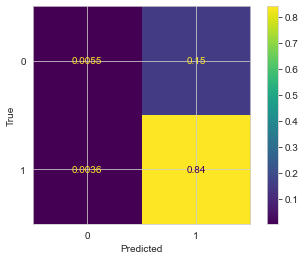

In [91]:
# Adding the results from the model to the analysis functions
cm = confusion_matrix(y_test, y_pred, normalize='all')
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()
cmd.ax_.set(xlabel = 'Predicted', ylabel='True')
print(classification_report(y_test, y_pred))

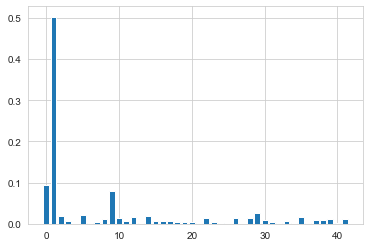

In [92]:
# We want to find out why the model made its decisions with a feature importance graph
importance = dtree.feature_importances_
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [93]:
# We want to see if we get any benefit from using a different type of classifier so lets
# test the Radom Forest Classifier Model
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=100)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

              precision    recall  f1-score   support

           0       0.59      0.03      0.06    135323
           1       0.85      1.00      0.92    737536

    accuracy                           0.85    872859
   macro avg       0.72      0.51      0.49    872859
weighted avg       0.81      0.85      0.78    872859



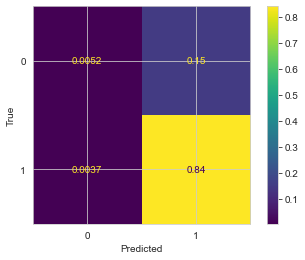

In [94]:
cm = confusion_matrix(y_test, y_pred, normalize='all')
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()
cmd.ax_.set(xlabel = 'Predicted', ylabel='True')
print(classification_report(y_test, y_pred))

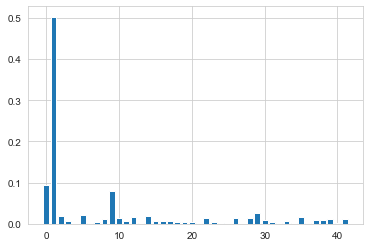

In [95]:
importance = dtree.feature_importances_
plt.bar([x for x in range(len(importance))], importance)
plt.show()

### The code below is a reinitialization of the code from before but changing the desired show recommendation satisfaction level to 8 and 9 instead of 7 to compare models

The below section is a reset on the model to include only a satisfaction rating of 8 and above

              precision    recall  f1-score   support

           0       0.61      0.35      0.44    319951
           1       0.70      0.87      0.78    552908

    accuracy                           0.68    872859
   macro avg       0.65      0.61      0.61    872859
weighted avg       0.67      0.68      0.65    872859



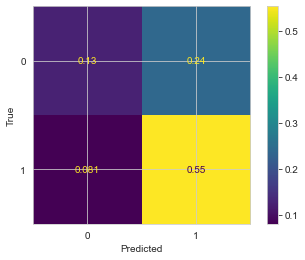

In [96]:
# Satisfaction 8 code repeat from before to reset model

def calc(row):
    if row['rating'] >=8:
        return 1
    else:
        return 0

genredf = pd.read_csv('anime.csv')
ratingsdf = pd.read_csv('rating.csv').dropna()
ratingsdf = ratingsdf[ratingsdf['rating'] != -1]
genredf = genredf[genredf.type == 'TV']
genredf1 = genredf.drop(columns = ['name', 'type', 'episodes', 'rating', 'members', 'anime_id'])
res = genredf.join(genredf1['genre'].str.split(', ').str.join('|').str.get_dummies())
res = res.drop(columns = ['genre', 'type', 'name', 'rating'])
res = res[res.episodes.apply(lambda x: x.isnumeric())]
res = res.astype({'episodes': 'int64'})
res = res.dropna()
res = ratingsdf.merge(res, left_on='anime_id', right_on='anime_id')
res['recommendation'] = res.apply(calc, axis=1)
xdf = res.drop(columns=['recommendation', 'rating', 'anime_id', 'user_id'])
X = xdf.iloc[:, :].values
features = list(res.drop(columns=['recommendation', 'rating', 'anime_id', 'user_id']).columns)
y = res['recommendation']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
dtree = DecisionTreeClassifier()
dtree = dtree.fit(X, y)
y_pred = dtree.predict(X_test)
cm = confusion_matrix(y_test, y_pred, normalize='all')
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()
cmd.ax_.set(xlabel = 'Predicted', ylabel='True')
print(classification_report(y_test, y_pred))

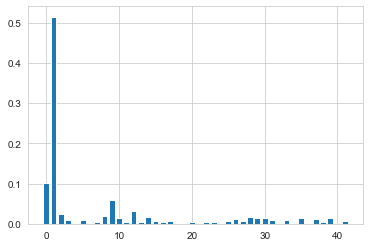

In [97]:
importance = dtree.feature_importances_
plt.bar([x for x in range(len(importance))], importance)
plt.show()

The below section is a reset on the model to include only a satisfaction rating of 9 and above.

              precision    recall  f1-score   support

           0       0.70      0.86      0.77    552722
           1       0.61      0.36      0.45    320137

    accuracy                           0.68    872859
   macro avg       0.65      0.61      0.61    872859
weighted avg       0.67      0.68      0.66    872859



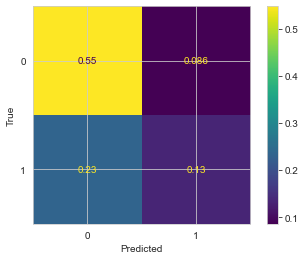

In [98]:
def calc(row):
    if row['rating'] >=9:
        return 1
    else:
        return 0

genredf = pd.read_csv('anime.csv')
ratingsdf = pd.read_csv('rating.csv').dropna()
ratingsdf = ratingsdf[ratingsdf['rating'] != -1]
genredf = genredf[genredf.type == 'TV']
genredf1 = genredf.drop(columns = ['name', 'type', 'episodes', 'rating', 'members', 'anime_id'])
res = genredf.join(genredf1['genre'].str.split(', ').str.join('|').str.get_dummies())
res = res.drop(columns = ['genre', 'type', 'name', 'rating'])
res = res[res.episodes.apply(lambda x: x.isnumeric())]
res = res.astype({'episodes': 'int64'})
res = res.dropna()
res = ratingsdf.merge(res, left_on='anime_id', right_on='anime_id')
res['recommendation'] = res.apply(calc, axis=1)
xdf = res.drop(columns=['recommendation', 'rating', 'anime_id', 'user_id'])
X = xdf.iloc[:, :].values
features = list(res.drop(columns=['recommendation', 'rating', 'anime_id', 'user_id']).columns)
y = res['recommendation']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
dtree = DecisionTreeClassifier()
dtree = dtree.fit(X, y)
y_pred = dtree.predict(X_test)
cm = confusion_matrix(y_test, y_pred, normalize='all')
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()
cmd.ax_.set(xlabel = 'Predicted', ylabel='True')
print(classification_report(y_test, y_pred))

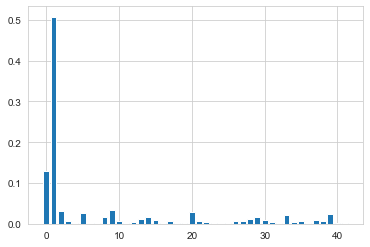

In [99]:
importance = dtree.feature_importances_
plt.bar([x for x in range(len(importance))], importance)
plt.show()

The below section is a reset on the model to include only a satisfaction rating of 10

              precision    recall  f1-score   support

           0       0.85      0.99      0.91    735505
           1       0.53      0.06      0.10    137354

    accuracy                           0.84    872859
   macro avg       0.69      0.52      0.51    872859
weighted avg       0.80      0.84      0.79    872859



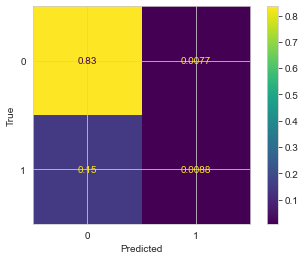

In [100]:
def calc(row):
    if row['rating'] == 10:
        return 1
    else:
        return 0

genredf = pd.read_csv('anime.csv')
ratingsdf = pd.read_csv('rating.csv').dropna()
ratingsdf = ratingsdf[ratingsdf['rating'] != -1]
genredf = genredf[genredf.type == 'TV']
genredf1 = genredf.drop(columns = ['name', 'type', 'episodes', 'rating', 'members', 'anime_id'])
res = genredf.join(genredf1['genre'].str.split(', ').str.join('|').str.get_dummies())
res = res.drop(columns = ['genre', 'type', 'name', 'rating'])
res = res[res.episodes.apply(lambda x: x.isnumeric())]
res = res.astype({'episodes': 'int64'})
res = res.dropna()
res = ratingsdf.merge(res, left_on='anime_id', right_on='anime_id')
res['recommendation'] = res.apply(calc, axis=1)
xdf = res.drop(columns=['recommendation', 'rating', 'anime_id', 'user_id'])
X = xdf.iloc[:, :].values
features = list(res.drop(columns=['recommendation', 'rating', 'anime_id', 'user_id']).columns)
y = res['recommendation']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
dtree = DecisionTreeClassifier()
dtree = dtree.fit(X, y)
y_pred = dtree.predict(X_test)
cm = confusion_matrix(y_test, y_pred, normalize='all')
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()
cmd.ax_.set(xlabel = 'Predicted', ylabel='True')
print(classification_report(y_test, y_pred))


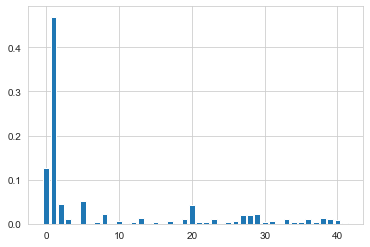

In [101]:
importance = dtree.feature_importances_
plt.bar([x for x in range(len(importance))], importance)
plt.show()